In [1]:
from torchvision import models
import torch
import torch.optim as optim

In [2]:
# get the features portion from VGG19
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
vgg.to('cuda:0')

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
from torchvision import transforms as tf

In [5]:
def transformation(img):
    tasks = tf.Compose([tf.Resize(400), tf.ToTensor(),
                        tf.Normalize((0.44,0.44,0.44),(0.22,0.22,0.22))])
    img = tasks(img)[:3,:,:].unsqueeze(0)    
    return img

In [6]:
from PIL import Image
img1 = Image.open("zebra.jpg")
img2 = Image.open("mod1.jpg")

In [7]:
img1 = transformation(img1).to('cuda:0')
img2 = transformation(img2).to('cuda:0')

In [18]:
def get_features(image, model):
    layers = {'0': 'conv1_1', '5': 'conv2_1',  '10': 'conv3_1', 
              '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
    x = image
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x     
    return features

In [19]:
img1_features = get_features(img1, vgg)
img2_features = get_features(img2, vgg)

In [20]:
def correlation_matrix(tensor):
    _, d, h, w = tensor.size()    
    tensor = tensor.view(d, h * w)    
    correlation = torch.mm(tensor, tensor.t())
    return correlation

In [21]:
correlations = {l: correlation_matrix(img2_features[l]) for l in img2_features}

In [22]:
weights = {'conv1_1': 1.50, 'conv2_1': 0.8, 'conv3_1': 0.85,
           'conv4_1': 110.21, 'conv5_1': 0.18}

target = img1.clone().requires_grad_(True).to('cuda:0')
optimizer = optim.Adam([target], lr=0.03)

In [23]:
for ii in range(1, 2001):
    
    ## calculate the content loss (from image 1 and target)
    target_features = get_features(target, vgg)
    loss = target_features['conv4_2'] - img1_features['conv4_2']
    content_loss = torch.mean((loss)**2)
    
    ## calculate the style loss (from image 2 and target)
    style_loss = 0
    for layer in weights:
        
        target_feature = target_features[layer]
        target_corr = correlation_matrix(target_feature)
        style_corr = correlations[layer]
        
        layer_loss = torch.mean((target_corr - style_corr)**2)
        layer_loss *= weights[layer]
        
        _, d, h, w = target_feature.shape
        style_loss += layer_loss / (d * h * w)   
    
    total_loss =  style_loss + content_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    print('epoch : ',ii,'  loss:  ',total_loss.cpu().data.numpy())

epoch :  1   loss:   11380.238
epoch :  2   loss:   10191.881
epoch :  3   loss:   8280.078
epoch :  4   loss:   6792.6787
epoch :  5   loss:   5775.5356
epoch :  6   loss:   5029.964
epoch :  7   loss:   4430.3257
epoch :  8   loss:   3943.0852
epoch :  9   loss:   3560.472
epoch :  10   loss:   3250.913
epoch :  11   loss:   2991.5347
epoch :  12   loss:   2771.243
epoch :  13   loss:   2581.7546
epoch :  14   loss:   2418.709
epoch :  15   loss:   2278.551
epoch :  16   loss:   2157.4036
epoch :  17   loss:   2051.6516
epoch :  18   loss:   1958.1826
epoch :  19   loss:   1875.2693
epoch :  20   loss:   1801.198
epoch :  21   loss:   1734.2635
epoch :  22   loss:   1673.1985
epoch :  23   loss:   1617.3422
epoch :  24   loss:   1565.9108
epoch :  25   loss:   1518.6876
epoch :  26   loss:   1475.042
epoch :  27   loss:   1434.6528
epoch :  28   loss:   1397.1426
epoch :  29   loss:   1362.1393
epoch :  30   loss:   1329.1783
epoch :  31   loss:   1298.1719
epoch :  32   loss:   1268

epoch :  257   loss:   379.47668
epoch :  258   loss:   381.22754
epoch :  259   loss:   383.7337
epoch :  260   loss:   382.05145
epoch :  261   loss:   379.5953
epoch :  262   loss:   379.9703
epoch :  263   loss:   376.51968
epoch :  264   loss:   375.24036
epoch :  265   loss:   376.22263
epoch :  266   loss:   374.11777
epoch :  267   loss:   372.69315
epoch :  268   loss:   372.08533
epoch :  269   loss:   371.19287
epoch :  270   loss:   369.67612
epoch :  271   loss:   368.68964
epoch :  272   loss:   368.33838
epoch :  273   loss:   367.08112
epoch :  274   loss:   365.8887
epoch :  275   loss:   365.48944
epoch :  276   loss:   364.70282
epoch :  277   loss:   363.8454
epoch :  278   loss:   363.2371
epoch :  279   loss:   363.14542
epoch :  280   loss:   363.8351
epoch :  281   loss:   365.75677
epoch :  282   loss:   366.46994
epoch :  283   loss:   366.62463
epoch :  284   loss:   363.36926
epoch :  285   loss:   361.39465
epoch :  286   loss:   361.2224
epoch :  287   los

epoch :  509   loss:   275.62912
epoch :  510   loss:   275.82773
epoch :  511   loss:   275.23956
epoch :  512   loss:   275.38464
epoch :  513   loss:   275.21994
epoch :  514   loss:   274.47266
epoch :  515   loss:   274.22217
epoch :  516   loss:   274.00424
epoch :  517   loss:   272.48584
epoch :  518   loss:   271.66998
epoch :  519   loss:   270.82306
epoch :  520   loss:   270.56674
epoch :  521   loss:   270.55582
epoch :  522   loss:   269.81323
epoch :  523   loss:   269.60437
epoch :  524   loss:   269.855
epoch :  525   loss:   270.73846
epoch :  526   loss:   272.82385
epoch :  527   loss:   276.10385
epoch :  528   loss:   275.7151
epoch :  529   loss:   274.3107
epoch :  530   loss:   271.8245
epoch :  531   loss:   272.29584
epoch :  532   loss:   273.35422
epoch :  533   loss:   271.19366
epoch :  534   loss:   271.46646
epoch :  535   loss:   271.6928
epoch :  536   loss:   268.63492
epoch :  537   loss:   267.37894
epoch :  538   loss:   268.6455
epoch :  539   lo

epoch :  759   loss:   235.97873
epoch :  760   loss:   233.74571
epoch :  761   loss:   232.31337
epoch :  762   loss:   233.10918
epoch :  763   loss:   232.07774
epoch :  764   loss:   229.66179
epoch :  765   loss:   230.4169
epoch :  766   loss:   228.42006
epoch :  767   loss:   226.50835
epoch :  768   loss:   227.19473
epoch :  769   loss:   227.61304
epoch :  770   loss:   226.65303
epoch :  771   loss:   225.13538
epoch :  772   loss:   225.84601
epoch :  773   loss:   225.56563
epoch :  774   loss:   224.08879
epoch :  775   loss:   223.23848
epoch :  776   loss:   223.28398
epoch :  777   loss:   222.72346
epoch :  778   loss:   221.86548
epoch :  779   loss:   221.25555
epoch :  780   loss:   221.26277
epoch :  781   loss:   220.82314
epoch :  782   loss:   220.52716
epoch :  783   loss:   220.39989
epoch :  784   loss:   220.53073
epoch :  785   loss:   221.4303
epoch :  786   loss:   222.98834
epoch :  787   loss:   222.93065
epoch :  788   loss:   222.44853
epoch :  789

epoch :  1009   loss:   191.16838
epoch :  1010   loss:   191.79121
epoch :  1011   loss:   192.96414
epoch :  1012   loss:   194.38797
epoch :  1013   loss:   195.4649
epoch :  1014   loss:   193.02216
epoch :  1015   loss:   190.57277
epoch :  1016   loss:   189.3245
epoch :  1017   loss:   190.80911
epoch :  1018   loss:   192.03777
epoch :  1019   loss:   190.2603
epoch :  1020   loss:   189.95633
epoch :  1021   loss:   191.34613
epoch :  1022   loss:   191.17648
epoch :  1023   loss:   190.27283
epoch :  1024   loss:   188.53888
epoch :  1025   loss:   188.27548
epoch :  1026   loss:   189.24681
epoch :  1027   loss:   188.08176
epoch :  1028   loss:   187.42706
epoch :  1029   loss:   188.1749
epoch :  1030   loss:   188.26195
epoch :  1031   loss:   188.81358
epoch :  1032   loss:   190.94168
epoch :  1033   loss:   194.40157
epoch :  1034   loss:   199.21098
epoch :  1035   loss:   196.35391
epoch :  1036   loss:   191.46527
epoch :  1037   loss:   188.46028
epoch :  1038   lo

epoch :  1252   loss:   166.87614
epoch :  1253   loss:   167.85735
epoch :  1254   loss:   167.131
epoch :  1255   loss:   166.38757
epoch :  1256   loss:   166.80211
epoch :  1257   loss:   166.62303
epoch :  1258   loss:   165.76587
epoch :  1259   loss:   165.65425
epoch :  1260   loss:   165.77783
epoch :  1261   loss:   165.42137
epoch :  1262   loss:   164.96974
epoch :  1263   loss:   165.0404
epoch :  1264   loss:   165.16179
epoch :  1265   loss:   165.0684
epoch :  1266   loss:   165.21136
epoch :  1267   loss:   166.17593
epoch :  1268   loss:   167.69153
epoch :  1269   loss:   169.28378
epoch :  1270   loss:   168.65192
epoch :  1271   loss:   167.28331
epoch :  1272   loss:   166.07304
epoch :  1273   loss:   166.06834
epoch :  1274   loss:   166.50648
epoch :  1275   loss:   165.88312
epoch :  1276   loss:   165.4319
epoch :  1277   loss:   165.57628
epoch :  1278   loss:   165.41298
epoch :  1279   loss:   164.53784
epoch :  1280   loss:   163.94867
epoch :  1281   los

epoch :  1495   loss:   160.20021
epoch :  1496   loss:   160.46767
epoch :  1497   loss:   168.91223
epoch :  1498   loss:   168.01476
epoch :  1499   loss:   159.36617
epoch :  1500   loss:   161.0727
epoch :  1501   loss:   158.25188
epoch :  1502   loss:   155.43597
epoch :  1503   loss:   158.05106
epoch :  1504   loss:   159.64737
epoch :  1505   loss:   159.60092
epoch :  1506   loss:   161.55618
epoch :  1507   loss:   165.67082
epoch :  1508   loss:   161.56926
epoch :  1509   loss:   157.34067
epoch :  1510   loss:   156.82861
epoch :  1511   loss:   155.19539
epoch :  1512   loss:   155.09784
epoch :  1513   loss:   157.60963
epoch :  1514   loss:   156.84288
epoch :  1515   loss:   154.6359
epoch :  1516   loss:   154.509
epoch :  1517   loss:   153.32413
epoch :  1518   loss:   152.44667
epoch :  1519   loss:   152.40869
epoch :  1520   loss:   152.63724
epoch :  1521   loss:   152.70538
epoch :  1522   loss:   151.9807
epoch :  1523   loss:   152.61673
epoch :  1524   los

epoch :  1738   loss:   139.39868
epoch :  1739   loss:   139.6515
epoch :  1740   loss:   140.15796
epoch :  1741   loss:   140.81285
epoch :  1742   loss:   140.45316
epoch :  1743   loss:   137.68091
epoch :  1744   loss:   137.25626
epoch :  1745   loss:   138.75276
epoch :  1746   loss:   138.73065
epoch :  1747   loss:   138.70485
epoch :  1748   loss:   139.17975
epoch :  1749   loss:   139.09749
epoch :  1750   loss:   139.48758
epoch :  1751   loss:   140.86533
epoch :  1752   loss:   142.20584
epoch :  1753   loss:   140.34682
epoch :  1754   loss:   137.75465
epoch :  1755   loss:   138.19487
epoch :  1756   loss:   139.96327
epoch :  1757   loss:   139.15897
epoch :  1758   loss:   140.08174
epoch :  1759   loss:   144.5818
epoch :  1760   loss:   148.86948
epoch :  1761   loss:   148.24858
epoch :  1762   loss:   149.0682
epoch :  1763   loss:   145.26645
epoch :  1764   loss:   142.65128
epoch :  1765   loss:   144.513
epoch :  1766   loss:   145.32237
epoch :  1767   los

epoch :  1981   loss:   135.0141
epoch :  1982   loss:   135.09103
epoch :  1983   loss:   134.59665
epoch :  1984   loss:   134.13448
epoch :  1985   loss:   133.67593
epoch :  1986   loss:   133.13109
epoch :  1987   loss:   132.85672
epoch :  1988   loss:   132.92737
epoch :  1989   loss:   132.8476
epoch :  1990   loss:   132.46388
epoch :  1991   loss:   132.00558
epoch :  1992   loss:   131.67459
epoch :  1993   loss:   131.50862
epoch :  1994   loss:   131.3016
epoch :  1995   loss:   131.05873
epoch :  1996   loss:   130.78555
epoch :  1997   loss:   130.63081
epoch :  1998   loss:   130.63461
epoch :  1999   loss:   130.58995
epoch :  2000   loss:   130.58655


In [26]:
def tensor_to_image(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image *= np.array((0.22, 0.22, 0.22)) + np.array((0.44, 0.44, 0.44))
    image = image.clip(0, 1)
    return image

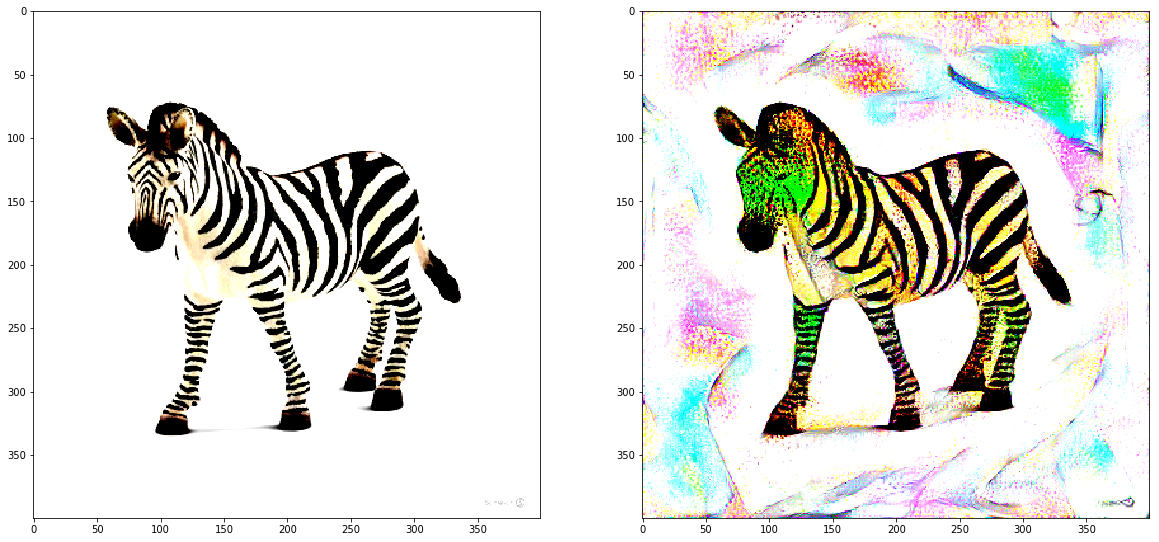

In [27]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor_to_image(img1))
ax2.imshow(tensor_to_image(target))